In [1]:
from ModelTransfuser.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch

import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [3]:
# Define the ModelTransfuser

# Time steps for the diffusion process
T = 50
t = torch.linspace(0, 1, T)

model = ModelTransfuser(T, train_data.shape)

model = model.load('ModelTransfuser/models/ModelTransfuser_t50_normed.pickle')

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
with open('ModelTransfuser/models/ModelTransfuser_t50_normed.pickle', 'rb') as f:
    ModelTransfuser = pickle.load(f)

In [11]:
epoch = np.arange(0, len(ModelTransfuser.train_loss))

plt.plot(epoch, np.array(ModelTransfuser.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(ModelTransfuser.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

AttributeError: type object 'ModelTransfuser' has no attribute 'train_loss'

## Data Generation

In [11]:
# Create random datapoints to denoise
sample_data_t1 = torch.randn(10000, train_data.shape[1])*2

In [12]:
sample_data_t0 = ModelTransfuser.sample(sample_data_t1, condition_mask=torch.zeros_like(sample_data_t1))

  0%|          | 0/50 [00:00<?, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x7ed61a5ecc80>
Traceback (most recent call last):
  File "/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/tqdm/std.py", line 1182, in __iter__
    yield obj
KeyboardInterrupt: 
  0%|          | 0/50 [00:56<?, ?it/s]


KeyboardInterrupt: 

In [1]:
sample_data_t0.mean(axis=0)

NameError: name 'sample_data_t0' is not defined

In [10]:
sample_data_t0.std(axis=0)

tensor([0.0143, 0.0141, 0.0105, 0.0072, 0.0073, 0.4777, 0.0127, 0.0460, 0.0484,
        0.0156, 0.0125, 0.0146, 0.0169, 0.0156])

In [14]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [15]:
denoising_data = ModelTransfuser.x_t.detach().numpy()
score_t = ModelTransfuser.score_t.detach().numpy()
dx = ModelTransfuser.dx_t.detach().numpy()
t = ModelTransfuser.t.detach().numpy()

In [16]:
scaling_factor = -0.5*ModelTransfuser.sigma**(2*t)*(1/T)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    sns.set_style("white")
    sns.kdeplot(x=denoising_data[:,i,0], y=denoising_data[:,i,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test.gif', writer=writer)

In [ ]:
denoising_data[0,1,:2]

In [41]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    plt.quiver(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], -dx[0,:i+1,0], -dx[0,:i+1,1], scale=1, scale_units='xy', width=0.003)
    plt.scatter(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], s=20, marker='x', color='black')
    #plt.hist2d(denoising_data[:,i,0], denoising_data[:,i,1])
    plt.tight_layout()

    #plt.scatter(denoising_data[:,i,0], denoising_data[:,i,1], s=0.5)
    #for j in range(len(denoising_data)):
    #    plt.arrow(denoising_data[j,i,0], denoising_data[j,i,1], score_t[j,i,0]*scaling_factor[i], score_t[j,i,1]*scaling_factor[i], color='black', head_width=0.05, alpha=0.6)

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_quiver.gif', writer=writer)

In [ ]:
dx[0,0,0]

In [46]:
val_data[:1]

tensor([[-2.7104, -2.8187,  0.0938,  0.5076,  0.4899,  4.5705, -0.0844, -0.2125,
          0.2124, -0.0435, -0.0080,  0.2303,  0.0644,  0.0697]])

In [4]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [5]:
mask

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
ModelTransfuser.sample(data=val_data[0], condition_mask=mask)

AttributeError: 'ModelTransfuser' object has no attribute 'mean'

In [50]:
p = ModelTransfuser.sample(val_data[1:2], condition_mask=mask)

100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


In [51]:
print(p.mean(axis=0))
print(p.std(axis=0))
print(val_data[1:2])

tensor([-2.0732, -2.8269, -0.3006,  0.5711,  0.5224,  9.5894,  0.1854,  0.1740,
        -0.1011,  0.3229,  0.0553,  0.6386,  0.4327,  0.2450])
tensor([0.0121, 0.0178, 0.0107, 0.0049, 0.0048, 0.1372, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[-2.0697, -2.7872, -0.3723,  0.4962,  0.4666,  7.0081,  0.1854,  0.1740,
         -0.1011,  0.3229,  0.0553,  0.6386,  0.4327,  0.2450]])


In [52]:
(val_data[1:2]-p.mean(axis=0))

tensor([[ 3.4840e-03,  3.9677e-02, -7.1664e-02, -7.4929e-02, -5.5735e-02,
         -2.5813e+00, -2.9802e-08,  0.0000e+00, -3.7253e-08, -5.9605e-08,
         -3.7253e-09, -1.1921e-07, -1.7881e-07, -5.9605e-08]])

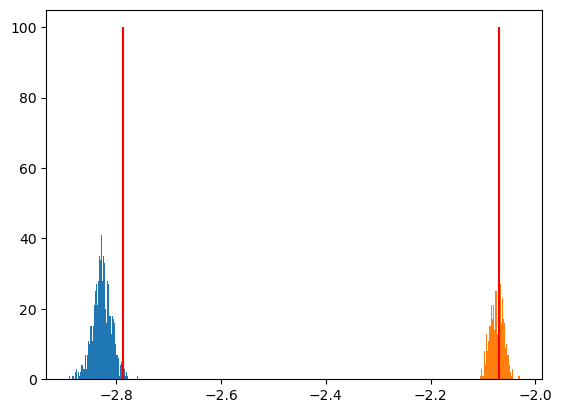

In [53]:
plt.hist(p[:,1], bins=100)
plt.hist(p[:,0], bins=100)
plt.vlines(val_data[1,1], 0, 100, color='red')
plt.vlines(val_data[1,0], 0, 100, color='red')
plt.show()

In [58]:
ape = np.zeros_like(val_data[:10])
for n, star in enumerate(val_data[:10]):
    p = ModelTransfuser.sample(star, condition_mask=mask)
    mu = p.mean(axis=0)
    std = p.std(axis=0)
    ape[n] = np.abs((star-mu)/star)*100

100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


In [62]:
np.median(ape, axis=0)

array([2.9328551e+00, 3.9428189e+00, 6.1926147e+01, 1.6646149e+01,
       1.2021675e+01, 2.5602119e+01, 7.8557887e-06, 1.0583341e-05,
       1.5789954e-05, 2.0434461e-05, 0.0000000e+00, 1.5545278e-05,
       2.5779958e-05, 1.3188928e-05], dtype=float32)

In [68]:
np.percentile(ape, [25, 50, 75], axis=0)[:,:2]

array([[1.15516281, 1.94009835],
       [2.93285525, 3.94281888],
       [4.13873422, 5.13782692]])

In [4]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [5]:
ape = torch.zeros_like(val_data[0])

for i in range(10):
    p = model.sample(val_data[i], condition_mask=mask)
    ape += 100*torch.abs((val_data[i]-p.mean(axis=1).squeeze())/val_data[i])

  0%|          | 0/1 [00:00<?, ?it/s]

0


  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
p = model.sample(val_data[:10], condition_mask=mask.repeat(10,1))

  0%|          | 0/10 [00:00<?, ?it/s]

0


In [22]:
ape[:6]/10

tensor([  5.7645,   4.4866, 152.0833,  13.7570,  16.3213,  32.5402])

In [7]:
a.mean(axis=1)[:,:2]

tensor([[-2.6575, -2.8029],
        [-2.1130, -2.8629],
        [-2.1061, -3.0447],
        [-2.1596, -3.2153],
        [-2.0114, -3.0088],
        [-2.0688, -3.0615],
        [-2.2646, -2.6822],
        [-2.3815, -2.9790],
        [-2.2638, -3.0696],
        [-2.3773, -2.8659]])

In [8]:
a.std(axis=1)[:,:2]

tensor([[0.0077, 0.0093],
        [0.0057, 0.0084],
        [0.0060, 0.0091],
        [0.0080, 0.0091],
        [0.0067, 0.0093],
        [0.0075, 0.0100],
        [0.0064, 0.0096],
        [0.0063, 0.0087],
        [0.0058, 0.0086],
        [0.0062, 0.0083]])

In [10]:
val_data[:10,:2]

tensor([[-2.7104, -2.8187],
        [-2.0697, -2.7872],
        [-1.9933, -2.9700],
        [-2.0780, -3.3935],
        [-2.0728, -3.1693],
        [-1.6190, -2.7599],
        [-2.3552, -2.8344],
        [-2.5175, -3.1621],
        [-2.3198, -3.1974],
        [-2.4158, -2.9486]])

In [11]:
torch.mean(100*(val_data[:100]-a.mean(axis=1))/val_data[:10], axis=0)[:6]

tensor([ -2.1290,   1.2679, -10.5253,  -5.5251, -11.1213,  -3.5668])